# Brain Tumor Classification

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# Import data managing libraries
import numpy as np
import pandas as pd

# Import Tensorflow
import tensorflow as tf
import tensorflow.keras as keras

# Plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import random
# Set the seed for repeatability
seed = 42

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for Python's built-in random module
random.seed(42)

In [3]:
from functions import process_data
import os

# Define data folder
data_folder = "data/"

# Define train, val, test folders
train_folder = os.path.join(data_folder, "Training/")
test_folder = os.path.join(data_folder, "Testing/")
val_folder = os.path.join(data_folder, "Validation/")

# Define our data directories
train_data_dir = train_folder
test_data_dir = test_folder
val_data_dir = val_folder

train_gen, test_gen, val_gen = process_data(256, 32, train_data_dir, test_data_dir, val_data_dir)

Found 2297 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


In [4]:
# Find out how the image data generators labeled our classes
train_class_labels = train_gen.class_indices
val_class_labels = train_gen.class_indices
test_class_labels = val_gen.class_indices

# Print the class labels
print("Train Class Labels:", train_class_labels)
print("Validation Class Labels:", val_class_labels)
print("Test Class Labels:", test_class_labels)

Train Class Labels: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
Validation Class Labels: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
Test Class Labels: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [5]:
# Retrieve one batch of data from the generator
data_batch, label_batch = next(train_gen)

# Print the shape of the data batch and label batch
print("Data batch shape:", data_batch.shape)
print("Label batch shape:", label_batch.shape)

Data batch shape: (32, 256, 256, 3)
Label batch shape: (32, 4)


In [6]:
# import matplotlib.pyplot as plt

# # Retrieve one batch of images from the generator
# images, labels = train_gen.next()

# # Print the dimensions of the first image
# print("Image dimensions:", images[0].shape)

# # Define the class labels
# class_labels = {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

# # Display the first six images with their labels
# fig, ax = plt.subplots(2, 3, facecolor='white', figsize=(15, 8))

# for i in range(2):
#     for j in range(3):
#         # Calculate the index in the images and labels arrays
#         idx = i * 3 + j
        
#         # Get the class name from the label
#         class_name = [key for key, value in class_labels.items() if value == labels[idx]][0]
        
#         # Plot the image
#         ax[i, j].imshow(images[idx])
#         ax[i, j].set_title(f"Class: {class_name}")

# plt.show()

We want to implement cross-validation into the training process. There are no built in methods within keras that can allow for this to happen but there are methods in scikit-learn. We can take the generators that pre-priocess the data and append the images to a dataframe. From there we can then split the data using KFold. 

In [13]:
# Extract data and labels from the generated batches on train set
data_train, labels_train = [], []
for _ in range(len(train_gen)):
    images_train, batch_labels_train = train_gen.next()  # Get the next batch of data
    data_train.extend(images_train)
    labels_train.extend(batch_labels_train)

# Extract data and labels from the generated batches on test set
data_test, labels_test = [], []
for _ in range(len(test_gen)):
    images_test, batch_labels_test = test_gen.next()  # Get the next batch of data
    data_test.extend(images_train)
    labels_test.extend(batch_labels_test)

# Extract data and labels from the generated batches on validation set
data_val, labels_val = [], []
for _ in range(len(val_gen)):
    images_val, batch_labels_val = val_gen.next()  # Get the next batch of data
    data_val.extend(images_val)
    labels_val.extend(batch_labels_val)

# Flatten the image data
data_train_flat = np.array(data_train).reshape(len(data_train), -1)
data_test_flat = np.array(data_test).reshape(len(data_test), -1)
data_val_flat = np.array(data_val).reshape(len(data_val), -1)

# Create Dataframes for each set. Keep class labels in order
df_train_data = pd.DataFrame(data_train_flat)
df_train_labels = pd.DataFrame(labels_train, columns=["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"])
df_train = pd.concat([df_train_data, df_train_labels], axis=1)

df_test_data = pd.DataFrame(data_test_flat)
df_test_labels = pd.DataFrame(labels_test, columns=["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"])
df_test = pd.concat([df_test_data, df_test_labels], axis=1)

df_val_data = pd.DataFrame(data_val_flat)
df_val_labels = pd.DataFrame(labels_val, columns=["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"])
df_val = pd.concat([df_val_data, df_val_labels], axis=1)

In [15]:
df_train.head(5)

,0,1,2,3,4,5,6,7,8,9,...,196602,196603,196604,196605,196606,196607,glioma_tumor,meningioma_tumor,no_tumor,pituitary_tumor
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.015686,0.015686,0.015686,0.015686,0.015686,0.015686,0.0,0.0,1.0,0.0
1,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0
2,0.164706,0.164706,0.164706,0.129412,0.129412,0.129412,0.184314,0.184314,0.184314,0.145098,...,0.258824,0.258824,0.258824,0.196078,0.196078,0.196078,0.0,0.0,1.0,0.0
3,0.062745,0.062745,0.062745,0.062745,0.062745,0.062745,0.062745,0.062745,0.062745,0.062745,...,0.062745,0.062745,0.062745,0.062745,0.062745,0.062745,0.0,0.0,1.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0


In [14]:
# Display the shape of each DataFrame
print("Train DataFrame shape:", df_train.shape)
print("Test DataFrame shape:", df_test.shape)
print("Validation DataFrame shape:", df_val.shape)

Train DataFrame shape: (2297, 196612)
Test DataFrame shape: (416, 196612)
Validation DataFrame shape: (573, 196612)


Seems that the dataframe worked. We have almost 20,000 columns for image data and the last four columns are our labels. 

# Convolutinal Base

In [9]:
from tensorflow.keras.metrics import Precision, Recall

# Define metrics we want to log for the compile method callback
metrics = [
        Precision(name='precision'),
        Recall(name='recall'),
        'accuracy'
    ]


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu', input_shape=input_shape))
cnn.add(MaxPool2D(pool_size=(2,2)))

# Flatten Tensor
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))

# Define the output 
cnn.add(Dense(4, activation='softmax'))

cnn.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 16)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 254016)            0         
                                                                 
 dense (Dense)               (None, 128)               32514176  
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 32,515,908
Trainable params: 32,515,908
Non-trainable params: 0
____________________________________________

Epoch 1/30
72/72 [==============================] - 7s 58ms/step - loss: 1.4467 - precision: 0.7046 - recall: 0.4227 - accuracy: 0.6025 - val_loss: 0.5565 - val_precision: 0.8304 - val_recall: 0.7522 - val_accuracy: 0.8028
Epoch 2/30
72/72 [==============================] - 4s 50ms/step - loss: 0.3102 - precision: 0.8968 - recall: 0.8659 - accuracy: 0.8838 - val_loss: 0.4667 - val_precision: 0.8324 - val_recall: 0.7888 - val_accuracy: 0.8150
Epoch 3/30
72/72 [==============================] - 4s 51ms/step - loss: 0.0804 - precision: 0.9825 - recall: 0.9765 - accuracy: 0.9795 - val_loss: 0.4228 - val_precision: 0.8660 - val_recall: 0.8569 - val_accuracy: 0.8604
Epoch 4/30
72/72 [==============================] - 4s 49ms/step - loss: 0.0190 - precision: 0.9974 - recall: 0.9974 - accuracy: 0.9974 - val_loss: 0.4550 - val_precision: 0.8499 - val_recall: 0.8499 - val_accuracy: 0.8499
Epoch 5/30
72/72 [==============================] - 4s 50ms/step - loss: 0.0045 - precision: 1.0000 - recall

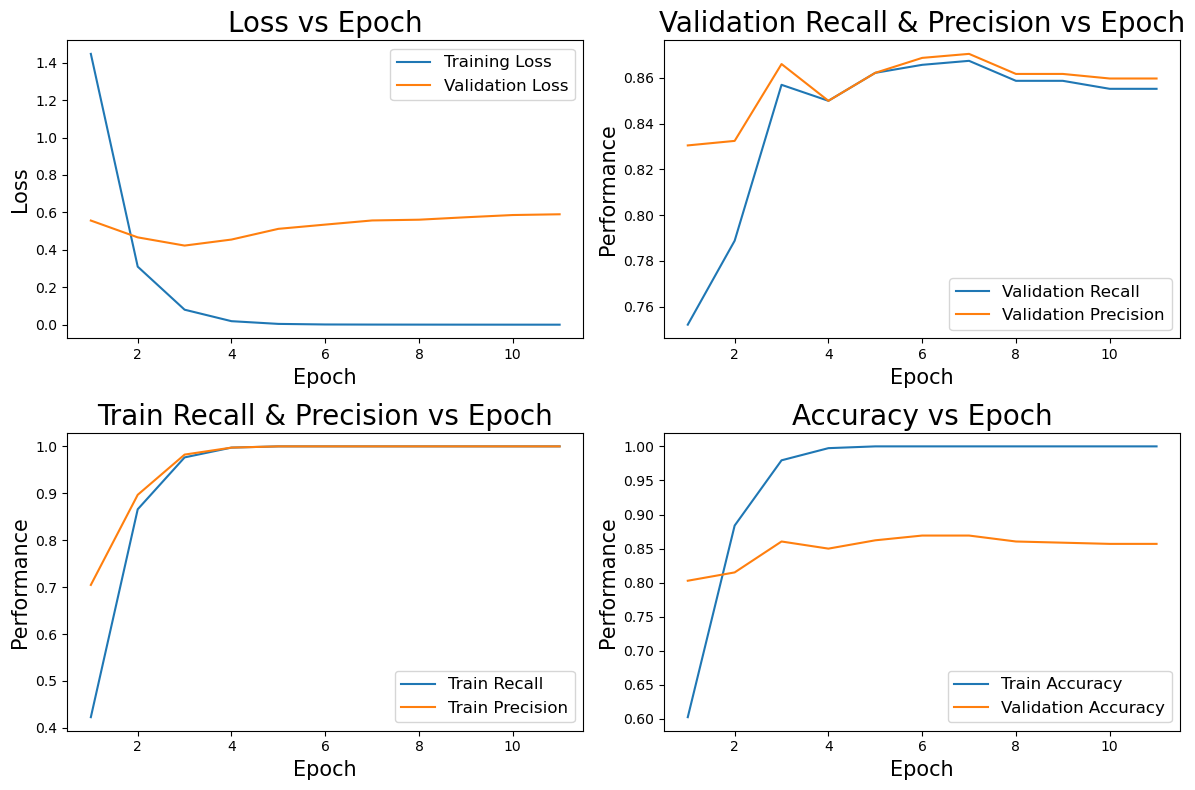

72/72 [==============================] - 3s 40ms/step - loss: 0.0240 - precision: 0.9991 - recall: 0.9991 - accuracy: 0.9991


c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


18/18 [==============================] - 1s 39ms/step - loss: 0.4228 - precision: 0.8660 - recall: 0.8569 - accuracy: 0.8604


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.023977,99.912930,99.912930,99.912930
1,Test,2.880321,66.753244,65.228426,65.736043
2,Validation,0.422785,86.596119,85.689354,86.038393


In [9]:
from functions import train_model, model_evaluate, view_history

conv = {}

# Train model
conv['Version1'] = train_model(cnn, train_gen, val_gen, 30)

# View history 
view_history(conv, 'Version1')

# Evalaute model
model_evaluate(cnn, train_gen, test_gen, val_gen)

It seems that our might be overfitting. We can tell because the val_loss curve does not decrease but rather starts increasing. Lets reduce the complexity of the model to see if it helps.

# CNN Version 2

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn2 = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn2.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu', input_shape=input_shape))
cnn2.add(MaxPool2D(pool_size=(2,2)))

# Flatten Tensor
cnn2.add(Flatten())
cnn2.add(Dense(68, activation='relu'))

# Define the output 
cnn2.add(Dense(4, activation='softmax'))

cnn2.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 252, 252, 16)      1216      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 16)     0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 254016)            0         
                                                                 
 dense_2 (Dense)             (None, 68)                17273156  
                                                                 
 dense_3 (Dense)             (None, 4)                 276       
                                                                 
Total params: 17,274,648
Trainable params: 17,274,648
Non-trainable params: 0
__________________________________________

Epoch 1/30
72/72 [==============================] - 7s 57ms/step - loss: 1.6901 - precision: 0.6677 - recall: 0.4706 - accuracy: 0.6073 - val_loss: 0.6303 - val_precision: 0.7760 - val_recall: 0.6771 - val_accuracy: 0.7347
Epoch 2/30
72/72 [==============================] - 4s 52ms/step - loss: 0.4021 - precision: 0.8730 - recall: 0.8232 - accuracy: 0.8520 - val_loss: 0.4866 - val_precision: 0.7925 - val_recall: 0.7731 - val_accuracy: 0.7818
Epoch 3/30
72/72 [==============================] - 4s 51ms/step - loss: 0.1760 - precision: 0.9546 - recall: 0.9434 - accuracy: 0.9504 - val_loss: 0.4767 - val_precision: 0.8312 - val_recall: 0.7993 - val_accuracy: 0.8185
Epoch 4/30
72/72 [==============================] - 4s 51ms/step - loss: 0.0680 - precision: 0.9869 - recall: 0.9835 - accuracy: 0.9861 - val_loss: 0.4416 - val_precision: 0.8380 - val_recall: 0.8307 - val_accuracy: 0.8360
Epoch 5/30
72/72 [==============================] - 4s 53ms/step - loss: 0.0282 - precision: 0.9965 - recall

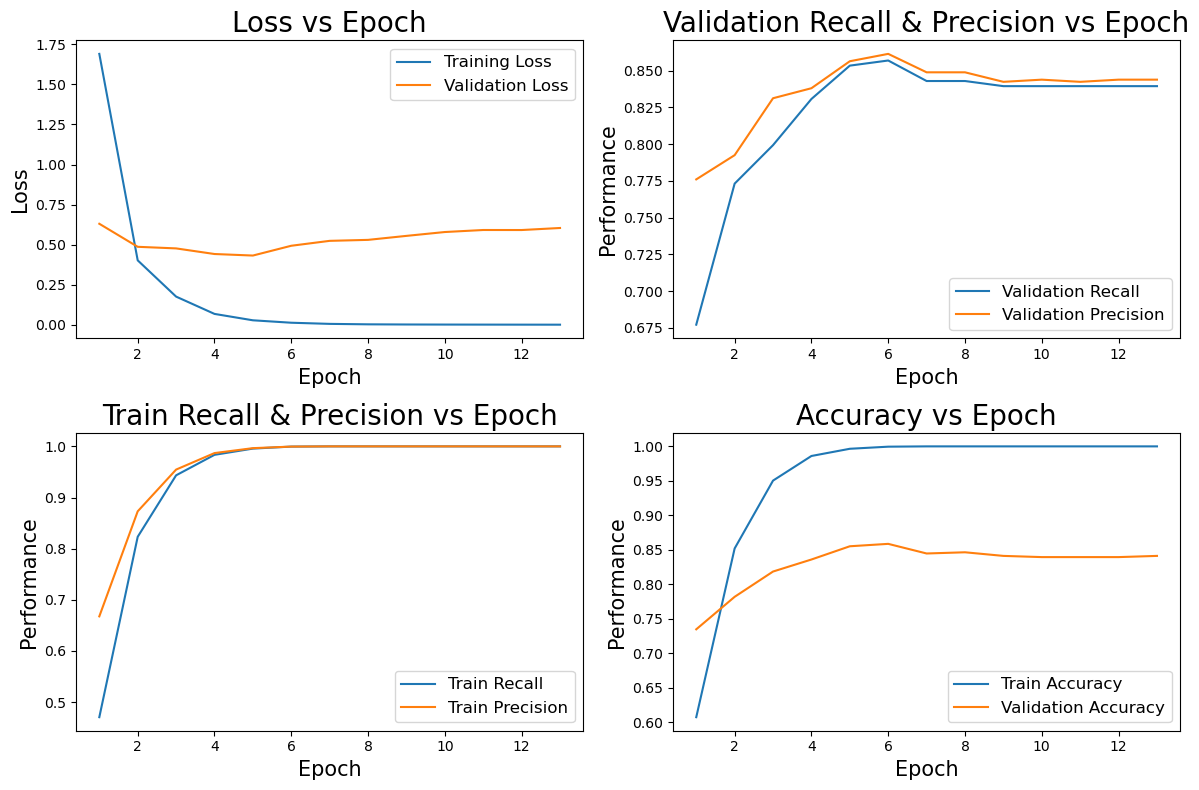

 1/13 [=>............................] - ETA: 0s - loss: 9.4334 - precision: 0.0625 - recall: 0.0625 - accuracy: 0.0625

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


18/18 [==============================] - 1s 41ms/step - loss: 0.4321 - precision: 0.8564 - recall: 0.8534 - accuracy: 0.8551


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.012334,100.000000,100.000000,100.000000
1,Test,2.347088,69.897962,69.543147,69.543147
2,Validation,0.432065,85.639232,85.340315,85.514832


In [11]:
from functions import train_model, model_evaluate, view_history

conv = {}
# Train model
conv['Version2'] = train_model(cnn2, train_gen, val_gen, 30)

# View history 
view_history(conv, 'Version2')

# Evalaute model
model_evaluate(cnn2, train_gen, test_gen, val_gen)

reducing the complexity didnt change much. It can be possible that we didnt overfit but rather the model is not complex enough to really capture the data features. Let make it more complex on purpose to see the difference.

# CNN versionn 3

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn3 = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn3.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu', input_shape=input_shape))
cnn3.add(MaxPool2D(pool_size=(2,2)))

# Flatten Tensor
cnn3.add(Flatten())
cnn3.add(Dense(128, activation='relu'))
cnn3.add(Dense(128, activation='relu'))

# Define the output 
cnn3.add(Dense(4, activation='softmax'))

cnn3.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 252, 252, 16)      1216      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 126, 126, 16)     0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 254016)            0         
                                                                 
 dense_4 (Dense)             (None, 128)               32514176  
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 4)                 516       
                                                      

Epoch 1/30
72/72 [==============================] - 5s 57ms/step - loss: 1.1493 - precision: 0.7410 - recall: 0.4923 - accuracy: 0.5873 - val_loss: 0.5771 - val_precision: 0.7973 - val_recall: 0.7277 - val_accuracy: 0.7644
Epoch 2/30
72/72 [==============================] - 4s 52ms/step - loss: 0.2768 - precision: 0.9141 - recall: 0.8946 - accuracy: 0.9034 - val_loss: 0.4487 - val_precision: 0.8298 - val_recall: 0.8168 - val_accuracy: 0.8220
Epoch 3/30
72/72 [==============================] - 4s 52ms/step - loss: 0.0678 - precision: 0.9804 - recall: 0.9778 - accuracy: 0.9787 - val_loss: 0.5130 - val_precision: 0.8375 - val_recall: 0.8272 - val_accuracy: 0.8325
Epoch 4/30
72/72 [==============================] - 4s 52ms/step - loss: 0.0288 - precision: 0.9948 - recall: 0.9948 - accuracy: 0.9948 - val_loss: 0.6343 - val_precision: 0.8269 - val_recall: 0.8255 - val_accuracy: 0.8255
Epoch 5/30
72/72 [==============================] - 4s 52ms/step - loss: 0.0093 - precision: 0.9987 - recall

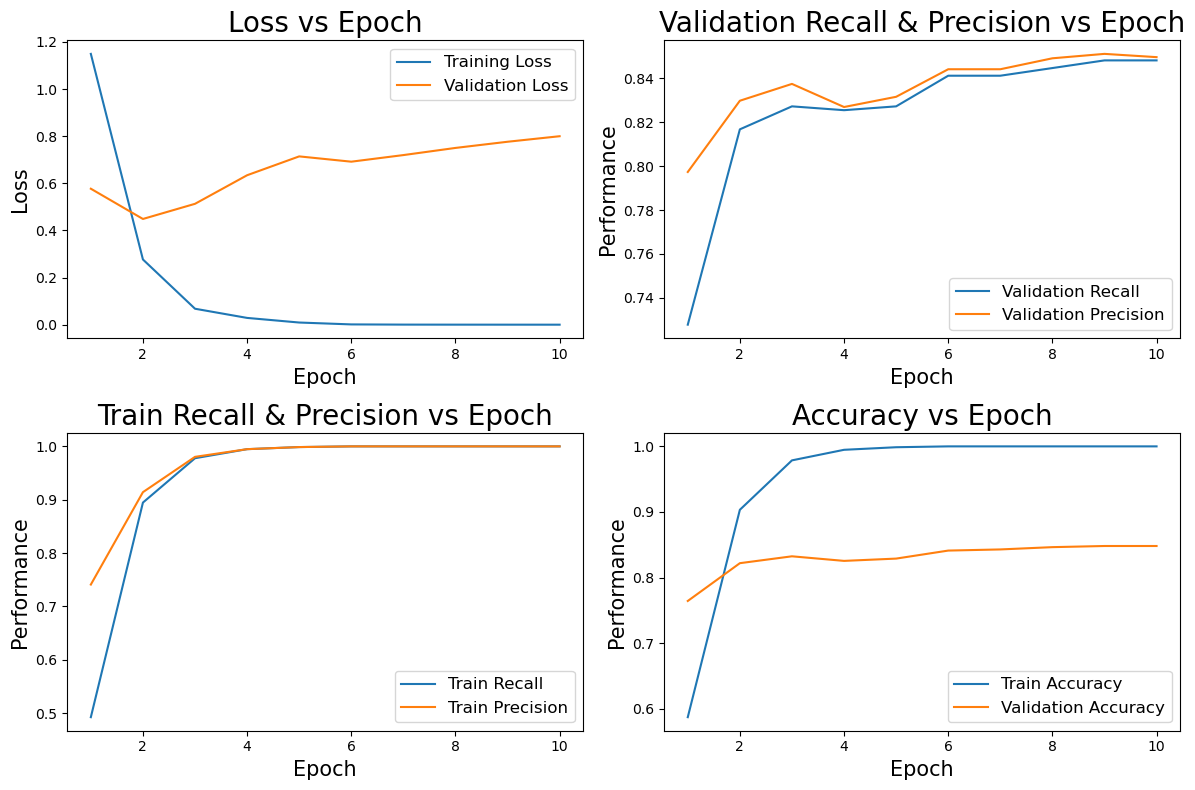

 2/13 [===>..........................] - ETA: 0s - loss: 6.4914 - precision: 0.1525 - recall: 0.1406 - accuracy: 0.1719

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


18/18 [==============================] - 1s 40ms/step - loss: 0.4487 - precision: 0.8298 - recall: 0.8168 - accuracy: 0.8220


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.064204,99.213284,98.824555,99.085766
1,Test,2.196057,67.654985,63.705581,65.228426
2,Validation,0.448737,82.978725,81.675392,82.198954


In [13]:
# Train model
conv['Version3'] = train_model(cnn3, train_gen, val_gen, 30)

# View history 
view_history(conv, 'Version3')

# Evalaute model
model_evaluate(cnn3, train_gen, test_gen, val_gen)

It seems that we were actually overfitting. We know for sure now since our validation loss curve went straight up. Lets reduce model complexity.

# CNN Version 4

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn4 = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn4.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu', input_shape=input_shape))
cnn4.add(MaxPool2D(pool_size=(2,2)))

# Flatten Tensor
cnn4.add(Flatten())
cnn4.add(Dense(32, activation='relu'))

# Define the output 
cnn4.add(Dense(4, activation='softmax'))

cnn4.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn4.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 252, 252, 16)      1216      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 126, 126, 16)     0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 254016)            0         
                                                                 
 dense_7 (Dense)             (None, 32)                8128544   
                                                                 
 dense_8 (Dense)             (None, 4)                 132       
                                                                 
Total params: 8,129,892
Trainable params: 8,129,892
Non-trainable params: 0
____________________________________________

Epoch 1/30
72/72 [==============================] - 4s 54ms/step - loss: 2.2094 - precision: 0.6546 - recall: 0.2530 - accuracy: 0.3966 - val_loss: 1.2003 - val_precision: 0.7629 - val_recall: 0.1291 - val_accuracy: 0.3944
Epoch 2/30
72/72 [==============================] - 4s 53ms/step - loss: 1.0533 - precision: 0.7107 - recall: 0.2556 - accuracy: 0.4919 - val_loss: 0.9784 - val_precision: 0.7939 - val_recall: 0.3159 - val_accuracy: 0.5218
Epoch 3/30
72/72 [==============================] - 4s 54ms/step - loss: 0.7972 - precision: 0.8375 - recall: 0.4780 - accuracy: 0.6861 - val_loss: 0.9193 - val_precision: 0.6904 - val_recall: 0.4904 - val_accuracy: 0.5899
Epoch 4/30
72/72 [==============================] - 4s 53ms/step - loss: 0.5809 - precision: 0.9189 - recall: 0.6064 - accuracy: 0.8206 - val_loss: 0.8146 - val_precision: 0.7409 - val_recall: 0.5340 - val_accuracy: 0.6824
Epoch 5/30
72/72 [==============================] - 4s 53ms/step - loss: 0.4263 - precision: 0.9435 - recall

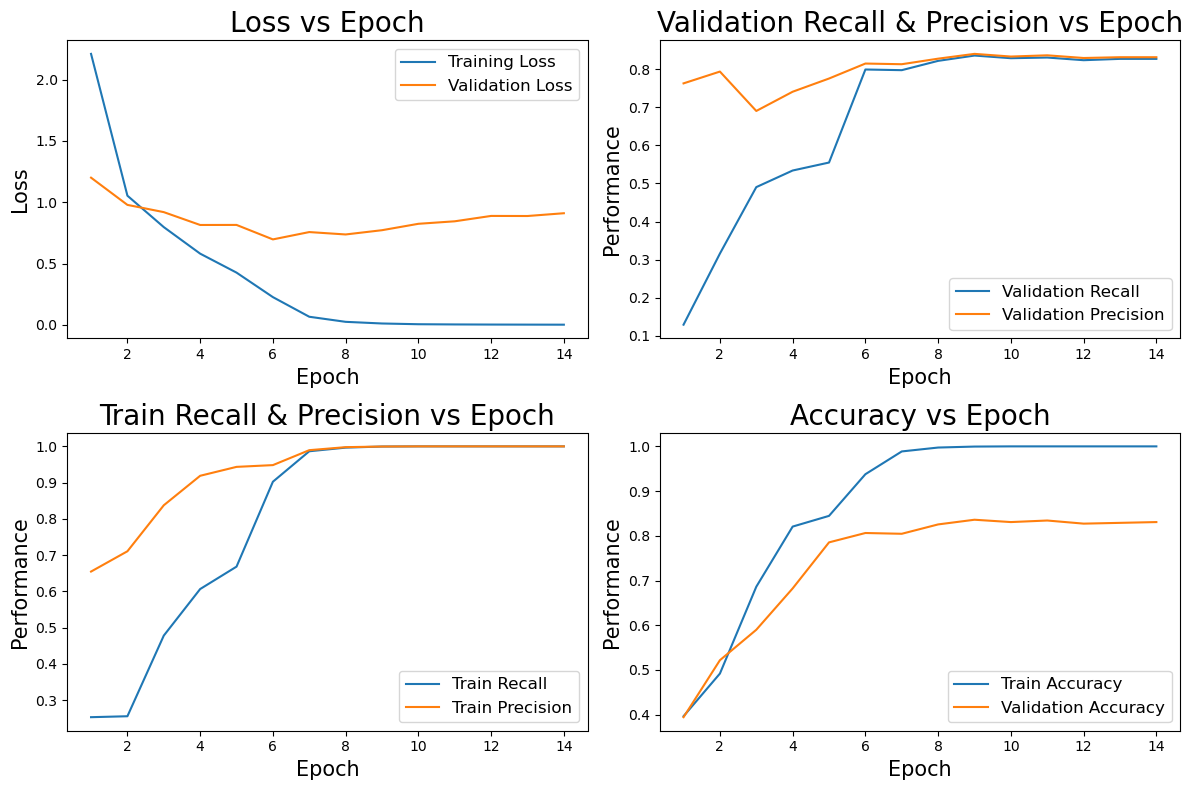

 1/13 [=>............................] - ETA: 0s - loss: 10.0324 - precision: 0.0312 - recall: 0.0312 - accuracy: 0.0312

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


18/18 [==============================] - 1s 42ms/step - loss: 0.6970 - precision: 0.8149 - recall: 0.7993 - accuracy: 0.8063


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.093248,98.950130,98.476273,98.781019
1,Test,2.541071,63.144332,62.182742,62.944162
2,Validation,0.696986,81.494659,79.930192,80.628270


In [15]:
# Train model
conv['Version4'] = train_model(cnn4, train_gen, val_gen, 30)

# View history 
view_history(conv, 'Version4')

# Evalaute model
model_evaluate(cnn4, train_gen, test_gen, val_gen)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn5 = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn5.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu', input_shape=input_shape))
cnn5.add(MaxPool2D(pool_size=(2,2)))

cnn5.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu', input_shape=input_shape))
cnn5.add(MaxPool2D(pool_size=(2,2)))

# Flatten Tensor
cnn5.add(Flatten())
cnn5.add(Dense(256, activation='relu'))

# Define the output 
cnn5.add(Dense(4, activation='softmax'))

cnn5.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn5.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 252, 252, 16)      1216      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 126, 126, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 122, 122, 16)      6416      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 61, 61, 16)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 59536)             0         
                                                                 
 dense_11 (Dense)            (None, 256)              

Epoch 1/30
72/72 [==============================] - 5s 57ms/step - loss: 1.3020 - precision: 0.6931 - recall: 0.4533 - accuracy: 0.5586 - val_loss: 0.7641 - val_precision: 0.7070 - val_recall: 0.6021 - val_accuracy: 0.6771
Epoch 2/30
72/72 [==============================] - 4s 52ms/step - loss: 0.4295 - precision: 0.8512 - recall: 0.8167 - accuracy: 0.8346 - val_loss: 0.5266 - val_precision: 0.8130 - val_recall: 0.7661 - val_accuracy: 0.7958
Epoch 3/30
72/72 [==============================] - 4s 52ms/step - loss: 0.1809 - precision: 0.9445 - recall: 0.9330 - accuracy: 0.9386 - val_loss: 0.5255 - val_precision: 0.8216 - val_recall: 0.8115 - val_accuracy: 0.8150
Epoch 4/30
72/72 [==============================] - 4s 50ms/step - loss: 0.1073 - precision: 0.9655 - recall: 0.9621 - accuracy: 0.9639 - val_loss: 0.5589 - val_precision: 0.8494 - val_recall: 0.8464 - val_accuracy: 0.8482
Epoch 5/30
72/72 [==============================] - 4s 51ms/step - loss: 0.0366 - precision: 0.9891 - recall

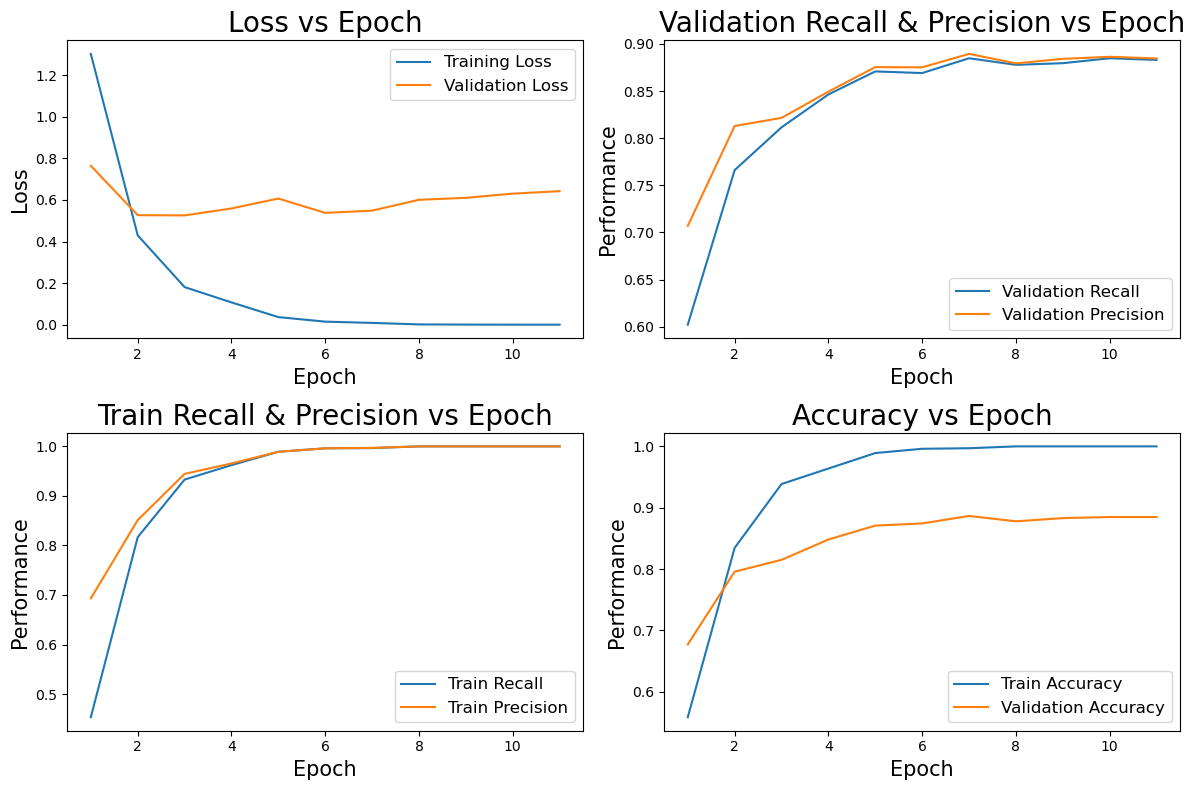

 2/13 [===>..........................] - ETA: 0s - loss: 8.9446 - precision: 0.1290 - recall: 0.1250 - accuracy: 0.1250             

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


18/18 [==============================] - 1s 41ms/step - loss: 0.5255 - precision: 0.8216 - recall: 0.8115 - accuracy: 0.8150


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.107946,96.593887,96.299523,96.430129
1,Test,2.780919,65.974027,64.467007,65.228426
2,Validation,0.525492,82.155478,81.151831,81.500870


In [18]:
# Train model
conv['Version5'] = train_model(cnn5, train_gen, val_gen, 30)

# View history 
view_history(conv, 'Version5')

# Evalaute model
model_evaluate(cnn5, train_gen, test_gen, val_gen)